In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import datetime

import pyvips as pv
import cv2
from sklearn.model_selection import StratifiedKFold

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [39]:
from multiprocessing import Pool
import subprocess

def cksums(filename):
    output = subprocess.run(['cksum', filename], capture_output=True, check=True)
    cksum, tsize, tifname = output.stdout.decode().split()
    return {'cksum': cksum, 'tifsize': tsize, 'tifname': tifname}

df = pd.DataFrame(outputs)
df.rename({'cksum': 'newcksum'}, axis=1, inplace=True)
df = df.merge(train, left_on='tifname', right_on='filename')
df[df['tif_cksum'] == df['newcksum']]

,newcksum,tifsize,tifname,filename,age,sex,melanoma_history,tif_cksum,tif_size,us_tif_url,eu_tif_url,as_tif_url,local_url,relapse


In [52]:
dlist = df[df['tif_cksum'] != df['newcksum'].astype(int)]
for idx, row in dlist.iterrows():
    filename = row['tifname']
    urls = [row['us_tif_url'], row['eu_tif_url'], row['as_tif_url']]
    for url in urls:
        os.remove(filename)
        subprocess.run(['s5cmd', '--no-sign-request', 'cp', url, filename])
        output = subprocess.run(['cksum', filename], capture_output=True)
        cksum = int(output.stdout.decode().split()[0])
        if cksum == row['tif_cksum']:
            break
    

cp s3://drivendata-competition-visiomel-public-us/images/2b1tip4m.tif /home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/2b1tip4m.tif
cp s3://drivendata-competition-visiomel-public-us/images/20b0hfk9.tif /home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/20b0hfk9.tif
cp s3://drivendata-competition-visiomel-public-us/images/3utxcbt7.tif /home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/3utxcbt7.tif


In [68]:
flist = os.listdir('../workspace/filter_png')
flist = [x[:-4] + '.tif' for x in flist]
flist = pd.Series(flist)
df[~df['filename'].isin(flist)].drop(['newcksum', 'tifsize', 'tifname'], axis=1).to_csv('../data/dl_list.csv')

In [31]:
train = pd.read_csv(f'{CFG.DATA_PATH}/train.csv')
train['filename'] = f'{os.path.abspath(os.getcwd())}/../data/originals/' + train['filename']
filenames = train['filename'].values.tolist()
outputs = []
with Pool(12) as p:
    for i in p.imap_unordered(cksums, filenames):
        outputs.append(i)
        print(i)

{'cksum': '80756657', 'tifsize': '27465352', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/w6uejlue.tif'}
{'cksum': '15925452', 'tifsize': '32159712', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/dhaohj9d.tif'}
{'cksum': '2376188009', 'tifsize': '33070516', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/k85cemwe.tif'}
{'cksum': '1145865362', 'tifsize': '33908676', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/mlibso49.tif'}
{'cksum': '3795133272', 'tifsize': '34088490', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/zvy86vvj.tif'}
{'cksum': '2798573061', 'tifsize': '63744208', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/../data/originals/l6s043vm.tif'}
{'cksum': '1661722161', 'tifsize': '49551528', 'tifname': '/home/broug/Desktop/visiomel-melanoma-runtime/notebooks/.

In [2]:
train_meta = pd.read_csv(f'{CFG.DATA_PATH}/train_metadata.csv')
train_labels = pd.read_csv(f'{CFG.DATA_PATH}/train_labels.csv')
train = train_meta.merge(train_labels, on='filename')

In [3]:
train = train.sort_values('tif_size').reset_index(drop=True)
train1 = train.iloc[:len(train)//2].reset_index(drop=True)
train2 = train.iloc[~train1.index].reset_index(drop=True)
train = pd.concat([train1, train2]).sort_index().reset_index(drop=True)

In [4]:
train['age'] = train['age'].apply(lambda x: x[1:3]).astype(int)
train['age'] = train['age'] / train['age'].max()
train["melanoma_history"] = train["melanoma_history"].replace({'YES': 1, 'NO': 0}).fillna(-1).astype(int)
train['sex'] = train['sex'].replace({1: 0}).replace({2: 1}).astype(int)
train = train.drop(['body_site', 'breslow', 'ulceration'], axis=1)

In [3]:
train = pd.read_csv(f'{CFG.DATA_PATH}/train.csv').drop(columns=['tif_cksum', 'tif_size'])
train.to_csv(f'{CFG.DATA_PATH}/train.csv', index=False)

In [27]:
img.height, img.width

(25424, 11104)

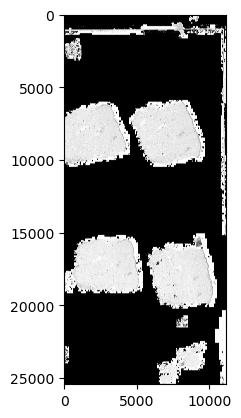

In [28]:
imgray = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2GRAY) / 255.
imgray = np.where(imgray == 1, 0, imgray)
plt.imshow(imgray, cmap='gray')

histogram, bin_edges = np.histogram(imgray, bins=256, range=(0, 1))

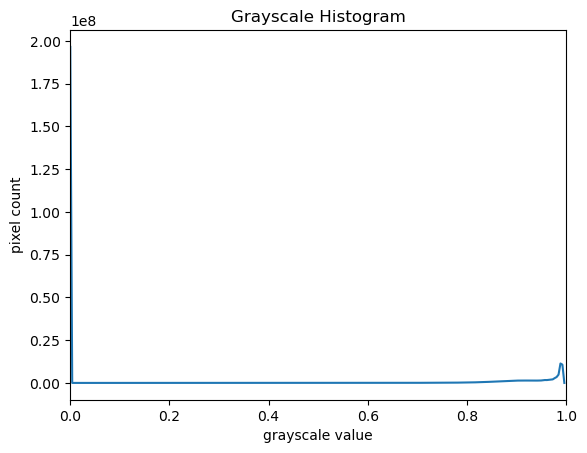

In [29]:
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here

Text(0, 0.5, 'Pixel count')

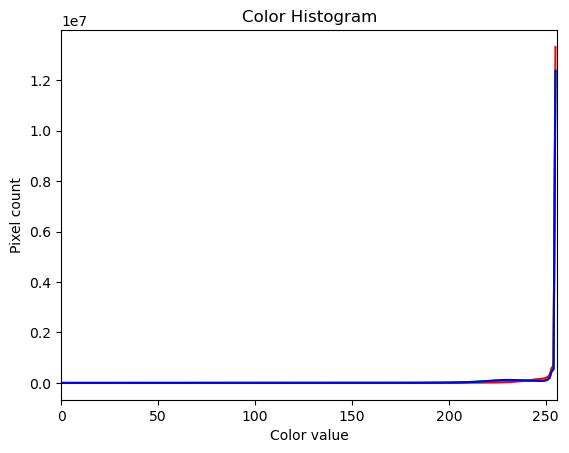

In [15]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
image = np.asarray(img)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        image[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

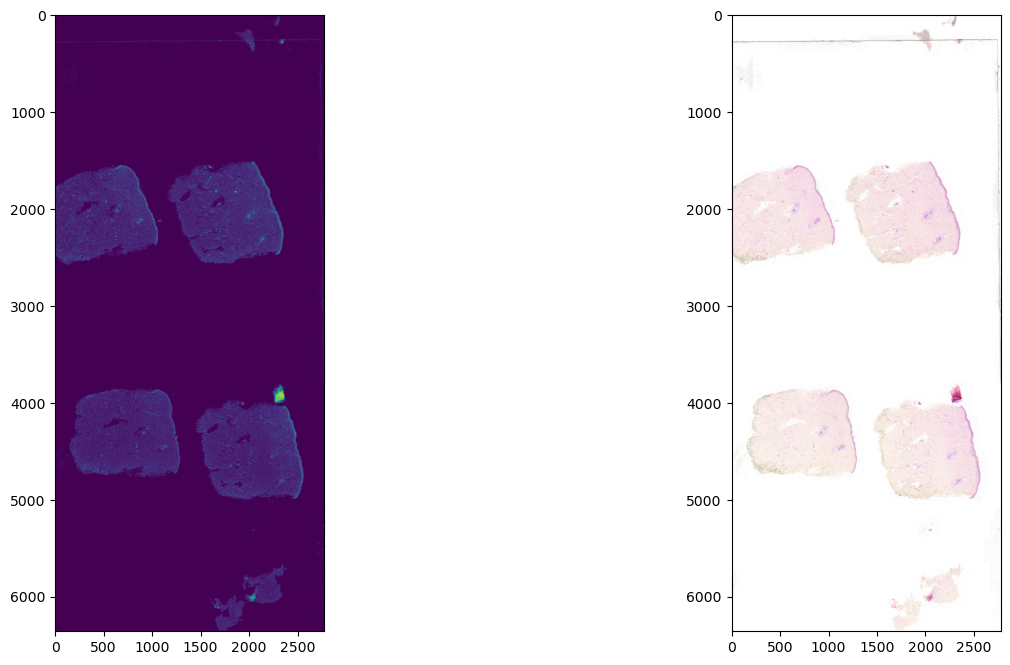

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(s)
axes[1].imshow(img)

In [26]:
print(np.min(s[1000, :]), np.max(s[1000, :]))
print(np.min(s[4000, :]), np.max(s[4000, :]))

0 27
0 111


In [36]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print( [flag for flag in flags if 'HSV' in flag])

['COLOR_BGR2HSV', 'COLOR_BGR2HSV_FULL', 'COLOR_HSV2BGR', 'COLOR_HSV2BGR_FULL', 'COLOR_HSV2RGB', 'COLOR_HSV2RGB_FULL', 'COLOR_RGB2HSV', 'COLOR_RGB2HSV_FULL']


In [1]:
import torch
torch.cuda.current_device()

0

In [ ]:
args = {'labels': 'relapse', 'fold': 1}
train, valid = split_df(train, args)

In [ ]:
# train = get_filenames(train)
#row = train.iloc[0]
img = read_img(train.loc[2, 'filename'])
img, _ = get_tiles(
    img,
    # tile_size=self.config.train.tile_size,
    # n_tiles=self.config.train.n_tiles,
    mode=0,
)
img = concat_tiles(
    img,
    n_tiles=36,
    image_size=256,
    # rand=self.is_train,
    # transform=self.transform,
)

In [ ]:
img.shape

(1536, 1536, 3)

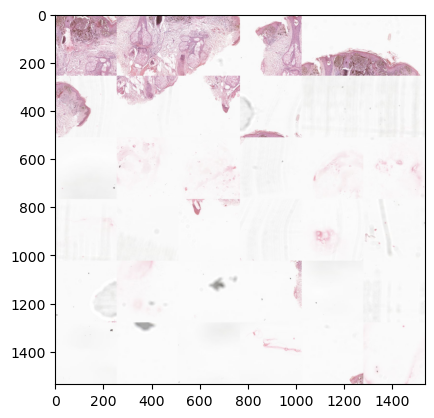

In [ ]:
plt.imshow(img)